In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import NLsolve,Roots;
pyplot(frame=:box,size=(500,350));

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end

xsqrt (generic function with 1 method)

# VGT

In [4]:
μc,μ0=μf(mDn,mDsc),μf(mDc,mDsn)

(0.9674107141493122, 0.9679003081419646)

In [5]:
qon_c(E)=xsqrt(2*μc*(E-mDn-mDsc+im*ΓDsc/2))
qon_0(E)=xsqrt(2*μ0*(E-mDc-mDsn+im*ΓDsn/2))

qon_0 (generic function with 1 method)

In [6]:
qon_c(mDn+mDsc-360e-6-im*24e-6)

0.0006321261575818416 + 0.0263995321486361im

In [7]:
xxx,www=gauss(30,0,1);

In [8]:
qi=zeros(ComplexF64,length(xxx)+2);
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [9]:
function find_qw(E,Λ;rs=1,qi=qi,wi=wi)
    qi[1],qi[2]=qon_c(E)*(-1)^(rs+1),qon_0(E)
    for i in eachindex(xxx)
        qi[i+2]=Λ*xxx[i]
        wi[i]=Λ*www[i]
    end
    nothing
end

find_qw (generic function with 1 method)

In [10]:
find_qw(mDn+mDsc-360e-6-im*24e-6,0.5)

In [11]:
sum(qi[3:end] .*wi)

0.125 + 0.0im

In [12]:
sum(wi)

0.5 + 0.0im

In [13]:
Vmat=zeros(ComplexF64,2*sublen,2*sublen);
Gmat=zeros(ComplexF64,2*sublen,2*sublen);
Tmat=zeros(ComplexF64,2*sublen,2*sublen);

In [14]:
function VMat!(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,I=0,plist=qi,des=Vmat)
    find_qw(E,Λ;rs=rs)
    k1,k2=plist[1],plist[2]

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DnDsc(E,plist[l], plist[m],k1,k1; a = a,a1=a1,I=I,isπ=false)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m],k2,k1; a = a,a1=a1,I=I,isπ=false)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DDscross(E,plist[l], plist[m],k1,k2; a = a,a1=a1,I=I,isπ=false)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_DcDsn(E,plist[l], plist[m],k2,k2; a = a,a1=a1,I=I,isπ=false)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

In [15]:
@btime VMat!(mDn+mDsc-360e-6-im*24e-6)

  1.814 ms (222 allocations: 4.06 KiB)


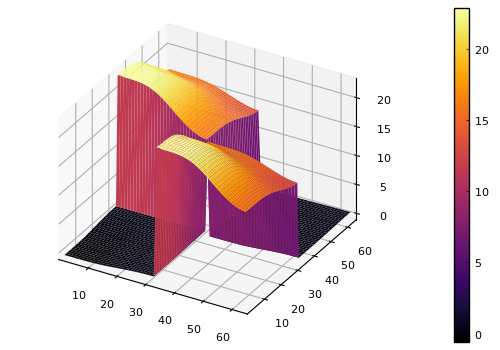

In [16]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

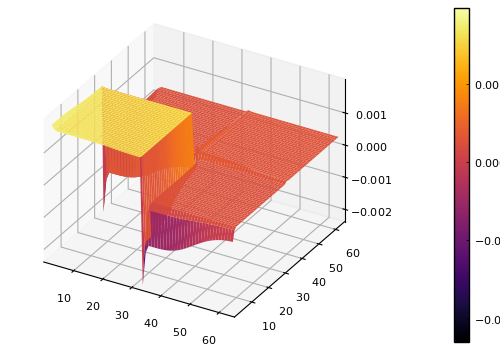

In [17]:
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)])

In [18]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDsc/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsn/2)

Gn (generic function with 1 method)

In [19]:
function GMat!(E;rs=1,Λ=0.5,qi=qi,wi=wi,des=Gmat)
    find_qw(E,Λ;rs=rs)
    μ1,μ2=μf(mDn,mDsc),μf(mDc,mDsn)
    k1,k2=qi[1],qi[2]
    
    tmp=zero(ComplexF64)
    
    i=1
    tmp=0.0+0.0im
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
        tmp+=-wi[j]*k1^2*Gc(E,qi[2+j])
    end
    des[(i-1)*sublen+1,(i-1)*sublen+1]=tmp+μ1*k1/(2π^2)*(log((Λ+k1)/(Λ-k1))-im*π)
    
    i=2
    tmp=0.0+0.0im
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
        tmp+=-wi[j]*k2^2*Gn(E,qi[2+j])
    end
    des[(i-1)*sublen+2,(i-1)*sublen+2]=tmp+μ2*k2/(2π^2)*(log((Λ+k2)/(Λ-k2))-im*π)
    
    return nothing
end

GMat! (generic function with 1 method)

In [20]:
function detVG(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,I=0)
    VMat!(E;rs=rs,Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;rs=rs,Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [21]:
function TMat!(E;rs=1,Λ=0.5,a = 0.0,a1=0.0,I=0,des=Tmat)
    VMat!(E;rs=rs,Λ=Λ,a=a,a1=a1,I=I)
    GMat!(E;rs=rs,Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

# parameters study

In [22]:
using Optim;

In [23]:
function inv_abst(x;rs=1,E=mDn+mDsc-273e-6,I=0)
    TMat!(E;rs=rs,Λ=x[1],I=I)
    return 1/abs(Tmat[1,1])
end

inv_abst (generic function with 1 method)

In [24]:
function absdet(x;rs=1,E=mDn+mDsc-360e-6-im*24e-6,I=0)
    abs(detVG(E;rs=rs,Λ=x[1],I=I))
end

absdet (generic function with 1 method)

In [25]:
function find_poles(pars)
    _rs,_lam=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ; Λ = _lam,rs = _rs)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsc - 333e-6, 0.0])
#     (tmp.zero[1]-mDn-mDsc)+im*tmp.zero[2]
end

find_poles (generic function with 1 method)

## RSI

In [26]:
let 
    tmpf(x)=inv_abst(x)
    init_val=[0.5]
    lower=[0.3]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.0002949479626333725
[0.7433714805943656]


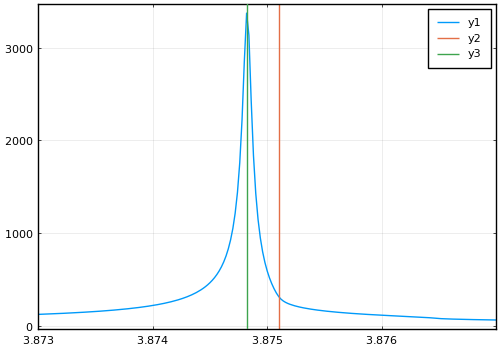

In [27]:
let Ev=collect(3.873:0.00002:3.877)
    function tmpf(E)
        TMat!(E;rs=1,Λ=0.7433714805943656)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

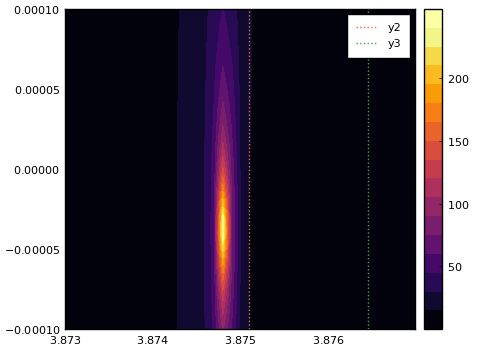

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [28]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;rs=1,Λ=0.7433714805943656)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsc],ls=:dot)
    vline!([mDc+mDsn],ls=:dot)
end

In [29]:
find_poles([1,0.7433714805943656])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, 0.0]
 * Zero: [3.8748256794965372, -3.7254339515610036e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [30]:
3.8748256794965372-mDn-mDsc

-0.0002743205034629881

## RSII

In [31]:
let 
    tmpf(x)=inv_abst(x;rs=2)
    init_val=[0.5]
    lower=[0.3]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00023054343605322336
[0.6516574286198279]


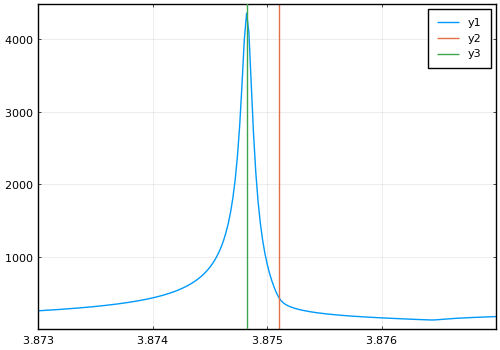

In [32]:
let Ev=collect(3.873:0.00002:3.877)
    function tmpf(E)
        TMat!(E;rs=2,Λ=0.6516574286198279)
        abs(Tmat[1,1])
    end
    resv=[tmpf(e) for e in Ev]
    plot(Ev,resv,xlims=(3.873,3.877))
    vline!([mDn+mDsc])
    vline!([mDn+mDsc-273e-6])
end

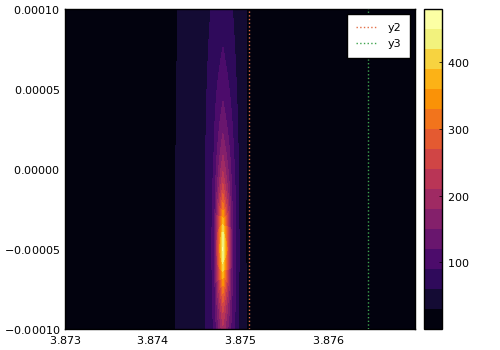

In [33]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ;rs=2,Λ=0.6516574286198279)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsc],ls=:dot)
    vline!([mDc+mDsn],ls=:dot)
end

In [34]:
find_poles([2,0.6516574286198279])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8747670000000003, 0.0]
 * Zero: [3.874824909153698, -4.926123220644044e-5]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [35]:
3.874824909153698-mDn-mDsc

-0.00027509084630228386